<hr>

# Program plots profiles of state variables and process tendencies at various locations and times of ENSO phase

<ul>
<li> Level 1: Mean profiles of states and tendencies during ENSO phase (seasons: monthly means) </li>
<li> Level 2: Time varying profiles during a season or seasonal transtion </li>
<li> Level 3: Statistical reltiosnhips between vertical processes and ENSO/forcing/dynamical strength </li>
</ul>
<hr>

In [1]:

import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
#from dateutil.relativedelta import relativedelta


import cartopy.crs as ccrs
import pandas as pd
import metpy as mpy
import dask as ds

In [37]:
### To Import My Functions ###
import vert_prof_func as mypy
import vert_prof_case_desc as mycase
import importlib


# Initial Simulation Information

In [38]:


importlib.reload(mypy) # Required because I am constantly editing scam_func.py
importlib.reload(mycase) # Required because I am constantly editing scam_func.py



''''' Which case to use '''''

#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'
#case_desc = np.array(['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc','rZMp','rpfrac','rTMS','rGW']) ; pref_out = 'revert'                      

#case_desc = ['C6','rC5','rCE2i','rC5p','rUW','rUWp','rZMp'] ; pref_out = 'revert_test'   
#case_desc = np.array(['C6','rC5']) ; pref_out = 'test'   
#nrevert = len(case_desc)
#case_type = ['cam6_revert']*nrevert



## SETTINGS INCLUDING ENSEMBLES ##

pref_out = 'lens1_test1'    
nens = 1

case_desc = ['CE1.E%01d'%(itt) for itt in range(1,nens+1)]
case_type  = ['lens1']*nens

#case_desc = np.array(['ERA5']+case_desc)
#case_type = np.array(['reanal']+case_type)


case_desc = np.array(case_desc)
case_type = np.array(case_type)



## INDIVIDUAL CASE SETTINGS/ADDITIONS ##

''''' Which phase of enso to work with and the nino SST region '''''
nino_region = 'nino34'




''' SEASON '''

seas_mons = np.array(["Jan","Feb","Dec"])

clim_anal = False

''''' Years for the analysis '''''

years_data = [1989,2001] # Year range of history files to read.


''' REGIONAL SPECS (LAT/LON/LEV) '''

#lats_in = -10. ; latn_in = 5.
#lonw_in = 150. ; lone_in = 220.
ppmin = 50. ; ppmax = 1000.



''''' Variable description '''''

var_cam = 'OMEGA'
ldiv = True # Calculate divergence from OMEGA

''''' Directory Information '''''

dir_croot = '/glade/p/cgd/amp/people/hannay/amwg/climo/' # Directories with climo files
dir_hroot = '/glade/p/cgd/amp/amwg/runs/' # Run firectories with history files

dir_proot = '/glade/u/home/rneale/python/python-figs/vert_proc/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'



## Variables ##

var_desc = {}

var_desc['DTCOND'] = ['dT/dt Total',86400.,1., -5.,5.,'K/day']
var_desc['DCQ']    = ['dq/dt Total',86400*1000.,1., -4.,4.,'g/kg/day']
var_desc['ZMDT']   = ['dT/dt Convection',86400., 1.,-5.,5.,'K/day']
var_desc['ZMDQ']   = ['dq/dt Convection',86400.*1000., 1.,-4.,4.,'g/kg/day']
var_desc['STEND_CLUBB'] = ['dT/dt turbulence',86400./1004., 1. ,-2.,8.,'K/day']
var_desc['OMEGA'] = ['OMEGA',-1., -100./86400., -0.004,0.004,'pa/s']
var_desc['DIV'] = ['Divergence',1., 100./86400., -0.0004,0.0004,'s^-1']
var_desc['T'] = ['Temperature',1., 1., -10.,10.,'K']
var_desc['U'] = ['Zonal Wind',1., 1., -5.,5.,'m/s']

''''' Named Regions '''''

reg_names = {}

#reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,210]  # Core of nino precip signal
reg_names['WP Dry']   = ['West Pac. Nino Dry.',-5.,10.,120.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,50.,160,190]       # Core of RWS convergence min.


# Include observations? #
lobs = False

# Pressure info.

p_levs = np.arange(ppmin,ppmax,50.)



###### NAMES CATALOGUE ######
#sim_names = cam_revert_list()
#sim_names = cam_vres_list()
#sim_names = mycase.cam_reanal_list()
sim_names = mycase.mdtf_case_list()




## Specify data frames ##

reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])
var_df = pd.DataFrame.from_dict(var_desc, orient='index',columns=['long_name','vscale','ovscale','xmin','xmax','vunits'])

display(reg_df)
print()
display(var_df)

reg = list(reg_names.keys())[0]

reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
print(reg_s)


nmnths = seas_mons.size
ncases = case_desc.size
nregions = reg_df.index.size

xmin = var_df.loc[var_cam]['xmin'] ; xmax=var_df.loc[var_cam]['xmax']
vunits = var_df.loc[var_cam]['vunits'] 
var_text = var_df.loc[var_cam]['long_name']   

if ldiv and var_cam == 'OMEGA':
    var_pname = 'DIV'
    var_text = var_df.loc[var_pname]['long_name']     
    vunits = var_df.loc[var_pname]['vunits'] 
    xmin = var_df.loc[var_pname]['xmin'] ; xmax=var_df.loc[var_pname]['xmax']
    

#%matplotlib inline
ds.config.set({"array.slicing.split_large_chunks": True})


,run name
ERA5,ERA5
ERAI,ERAI
C4,f40.1979_amip.track1.1deg.001
C5,30L_cam5301_FAMIP.001
C6,f.e20.FHIST.f09_f09.cesm2_1.001
...,...
CE2.E36,b.e21.BHISTcmip6.f09_g17.LE2-1301.006
CE2.E37,b.e21.BHISTcmip6.f09_g17.LE2-1301.007
CE2.E38,b.e21.BHISTcmip6.f09_g17.LE2-1301.008
CE2.E39,b.e21.BHISTcmip6.f09_g17.LE2-1301.009


,long_name,lat_s,lat_n,lon_w,lon_e
WP Dry,West Pac. Nino Dry.,-5.0,10.0,120.0,150


,long_name,vscale,ovscale,xmin,xmax,vunits
DTCOND,dT/dt Total,8.640000e+04,1.000000,-5.0000,5.0000,K/day
DCQ,dq/dt Total,8.640000e+07,1.000000,-4.0000,4.0000,g/kg/day
ZMDT,dT/dt Convection,8.640000e+04,1.000000,-5.0000,5.0000,K/day
ZMDQ,dq/dt Convection,8.640000e+07,1.000000,-4.0000,4.0000,g/kg/day
STEND_CLUBB,dT/dt turbulence,8.605578e+01,1.000000,-2.0000,8.0000,K/day
OMEGA,OMEGA,-1.000000e+00,-0.001157,-0.0040,0.0040,pa/s
DIV,Divergence,1.000000e+00,0.001157,-0.0004,0.0004,s^-1
T,Temperature,1.000000e+00,1.000000,-10.0000,10.0000,K
U,Zonal Wind,1.000000e+00,1.000000,-5.0000,5.0000,m/s


-5.0


# ENSO Phase Compositing of Tendencies 
- Read in hist timeseries
- Calculate SST nino timeseries
- Composites based on season for vertical profiles
- Composites vertical profiles minus climo.




**** **** **** **** **** **** **** **** **** 
**** CASE #  [1]  OF  1  ****
**** **** **** **** **** **** **** **** **** 
- Name =  CE1.E1  -> b.e11.B20TRC5CNBDRD.f09_g16.001
**** **** **** **** **** **** **** **** **** 

-- case_type files - type allowed
    -- Grabbing data type/case -- lens1 b.e11.B20TRC5CNBDRD.f09_g16.001
    -- Grabbing file(s) for LENS1(CESM1) - Variable =  OMEGA
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
/
c
    -- FILE(S) AVAILABLE TIME RANGE - >  1850  to 2006

Dataset required memory = 12421909392
-- case_type files - type allowed
    -- Grabbing data type/case -- lens1 b.e11.B20TRC5CNBDRD.f09_g16.001
    -- Grabbing file(s) for LENS1(CESM1) - Variable =  TS
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 138  total number of files)
/
c
    -- FILE(S) AVAILABLE TIME RANGE - >  1850  to 2006

Dataset required memory = 414272400
-- SET TIME RANGE OF TS DATA --  1989  to  2001
-- Calculating and plotting nino SST anomali

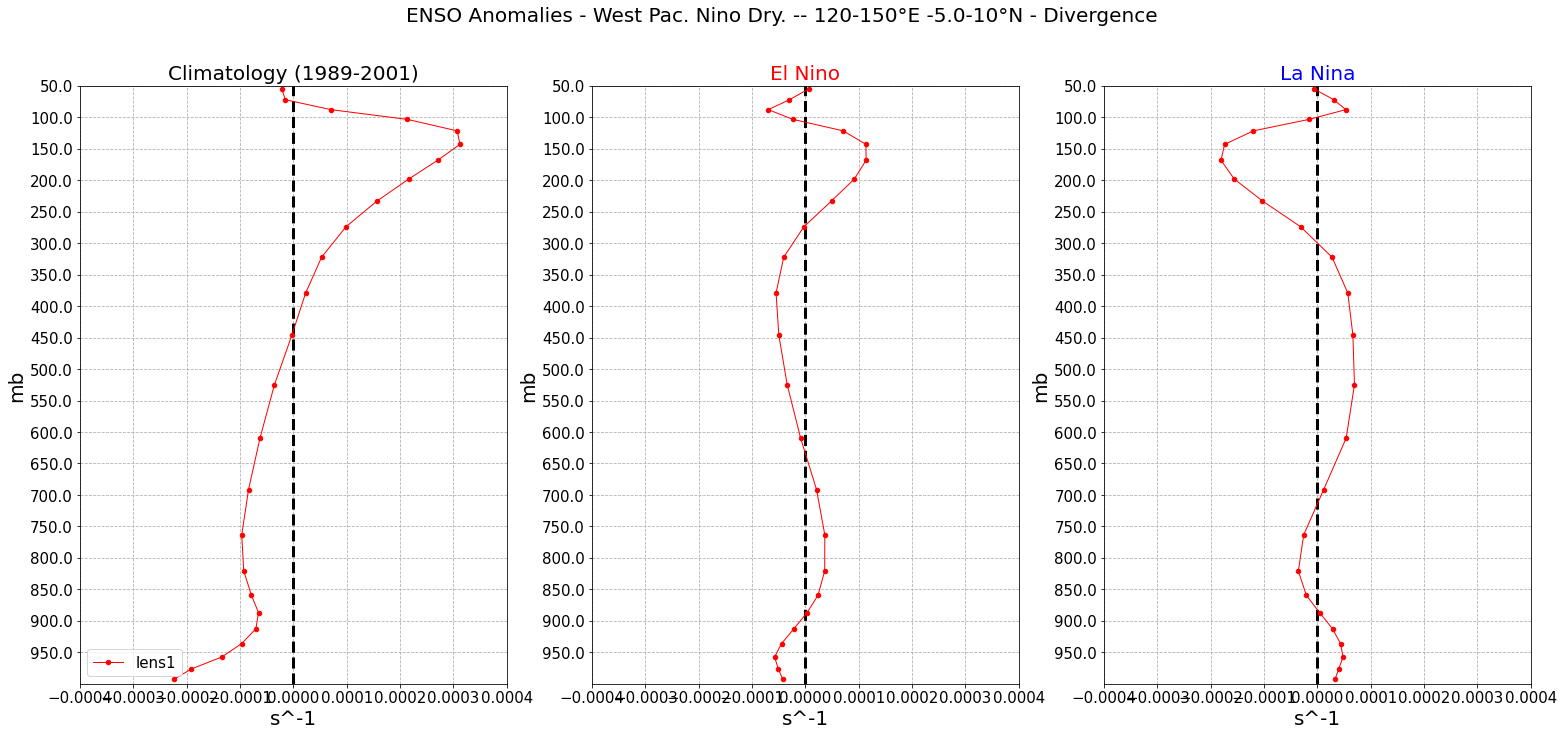

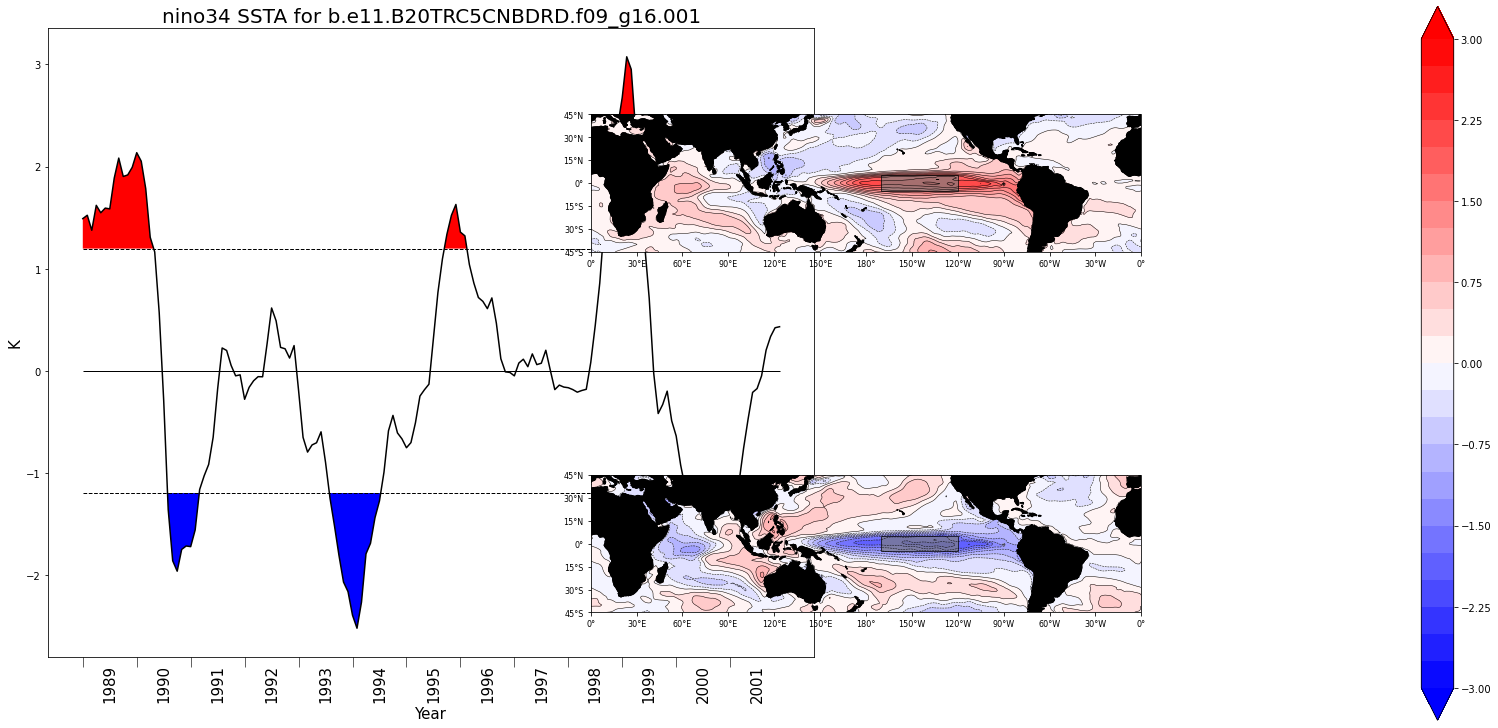

In [47]:
%%time
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
importlib.reload(mycase) # Required because I am constantly editing scam_func.py



# importlib.reload(mypy) # Required because I am constantly editing scam_func.py

### Read in history monthly mean files and composite profiles for tendencies###
dir_hroot = '/glade/p/cgd/amp/amwg/runs/'

#### Read in Data ####

yr0 = years_data[0]
yr1 = years_data[1]


nino_names = ['Climatology ('+str(yr0)+'-'+str(yr1)+')','El Nino','La Nina']








  ## PLOTTING RESOURCES

fign, axn = mp.subplots(1,3,figsize=(26, 11))  

nino_colors = ['black','red','blue']

'''
########################
##### LOOP CASES  ######
########################
'''


for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
    
    print('')
    print('')
    print('')
    print('**** **** **** **** **** **** **** **** **** ')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('**** **** **** **** **** **** **** **** **** ')
    print('- Name = ',case,' ->',sim_name)
    print('**** **** **** **** **** **** **** **** **** ')
    print('')   
        
        
## Read data in from files ##

# Construct required history file month-year array

#    hist_myr = np.array([".cam.h0.%d-%02d.nc"%(y, m) for y in range(yr0,yr1+1) for m in range(1,12+1)])
#    num_h0 = hist_myr.size
  

#    hfile_var = get_files_type(run_type,case_type,True) # Grab SST files
   
    files_ptr,var_name   = mypy.get_files_type(sim_name,case_type[icase],var_cam,years_data) # Grab variable
    
    
    
## TS FROM HISTORY FILES (just copy for h0 files if they are already read in)

    if case_type[icase] in ['cam6_revert']: # I think this effectively acts as a pointer, I hope!
        tfiles_ptr = files_ptr 
        tvar_name = 'TS'
    else :   
        tfiles_ptr,tvar_name = mypy.get_files_type(sim_name,case_type[icase],'TS',years_data) # Grab TS for nino timeseries


# Have to modify based on month 1 is jan and not feb
#    hfiles_ptr.time.dt.month[0]=1




#    hmonths = hfiles_ptr.time.dt.month    

    ''' TRMM FOR SPECIFIED YEARS '''
    
    print('-- SET TIME RANGE OF TS DATA -- ',yr0,' to ',yr1)
    print('-- Calculating and plotting nino SST anomalies')
    
    sst_data = tfiles_ptr[tvar_name].sel(time=slice(str(yr0), str(yr1)))
   
    
    ''' SST ANOMALY ROUTINE ARRAY '''
  
    sst_months =  sst_data.time.dt.strftime("%b")    
    inino_mons,inina_mons = mypy.nino_sst_anom(sim_name,sst_data,nino_region)
    
    print('-- NINO grab:  Done --')
   
    
    
    
    
    ''' Read in the fields and time average '''

    
    if var_name == 'DTCOND' and case in ['rC5','rUW']: 
            var_in = files_ptr['DTCOND']+files_ptr['DTV']
    if var_name == 'DCQ' and case in ['rC5','rUW']: 
            var_in = files_ptr['DCQ']+files_ptr['VD01']
    
    if var_name == 'STEND_CLUBB':
       
        if case in ['rC5','rUW'] : 
            
            var_in = 1005.*(files_ptr['DTV']
            +files_ptr['MACPDT']/1000.
            +files_ptr['CMFDT']) 
        else :
            var_in = files_ptr[var_name]           
    
    if var_name == 'DIV':  
            var_in = -files_ptr['OMEGA'].differentiate("lev")
   
#    if var_name in ['OMEGA','ZMDT','ZMDQ']:
#            var_in = files_ptr[var_name]
    
    
    ''' SUBSET SEASON MONTHS '''
    
#    print(files_ptr[var_name].dt)     
#    date_after_month = date.today()+ relativedelta(months=1)
#    print ('Today: ',date.today().strftime('%d/%m/%Y'))
#    print ('After Month:', dt.strftime('%d/%m/%Y'))

#    dt_index = files_ptr.indexes['time'].to_datetimeindex()
#    print(dt.date.today())
#    print(dt_index.month)
#    print(relativedelta(months=-1))
#    print(dt.date.today()+relativedelta(months=-10))

#    print(dt_index+relativedelta(months=+1))

#    print(dt_index.month)
    
    
#    time = files_ptr.time 
#    print(dt_index)
#    files_ptr['time'] = dt_index 
    
#    hmonths = files_ptr.time.dt.strftime("%b")
 
#    print(files_ptr.time.time)
#    print(pd.to_datetime(files_ptr.time))
    

    

    
 
   
        
# Just read in the season months and levs we need

    var_in = files_ptr[var_name].sel(time=slice(str(yr0),str(yr1)))
    
  
    if case_type[icase] in ['lens1','lens2']:
        print('-- "Compute" the variable array now (bring it up from lazy array) if != ANALYSES')
        %time var_in = var_in.compute()
    
# Grab time coord.
    time_in = var_in.time
    
    
    ''' Trim locations (lat/lev) for simplicity '''
    
    lev_in = var_in.lev
    ilevs = np.where(lev_in >= min(p_levs))
   
    ilevs = ilevs[0]
    lev = lev_in[ilevs]
    
    
# Check SST size with Variable size
    
    if sst_data.time.size != time_in.size : print('SST and VARIABLE sizes DO NOT MATCH - ',sst_data.time.size,' and ',time_in.size) 
        
    month_nums = time_in.dt.month   
    hmonths = time_in.dt.strftime("%b")



# Poor man's modifcation for lens1 ts
#    if case_type[icase] == 'lens1' :
#            month_nums = month_nums-1 # Set back 1 month
#            month_nums[month_nums ==-1] = 12 # Set -1 months back to 12
#    mon_obj = dt.datetime.strptime(mon_nums, "%m")


    lmon_seas = np.isin(hmonths,seas_mons) # Logical for seaon months in all months
    imon_seas = np.argwhere(lmon_seas)[:,0] # Indices
    hmon_seas = hmonths[imon_seas] # Subsetting full months.
    
    
# Seasonal selection for ninos 

#    lnino_seas = np.isin(hmonths[inino_mons],seas_mons) # Logical for season months in all months
#    inino_seas= inino_mons[np.argwhere(lnino_seas)[:,0]] # Indices of origin nino_mons that match the season
#    inino_seas = np.argwhere(lnino_seas)[:,0] # Indices of origin nino_mons that match the season
    
    
#    lnina_seas = np.isin(hmonths[inina_mons],seas_mons) # Logical for season months in all months
#    inina_seas= inina_mons[np.argwhere(lnina_seas)[:,0]] # Indices of origin nino_mons that match the season
#    inina_seas= np.argwhere(lnina_seas)[:,0] # Indices of origin nino_mons that match the season   
       
    var_in = var_in.loc[:,:,reg_s:reg_n,reg_w:reg_e] # Limit the levels
    
#  
    var_in = var_in[:,ilevs,:,:]   
    dp_lev = np.diff(lev)

    

## Much easier than above but doing the intersections of months and nino months.
    inino_seas,inino_ind,imon_nino_ind = np.intersect1d(inino_mons, imon_seas, return_indices=True)
    inina_seas,inina_ind,imon_nina_ind = np.intersect1d(inina_mons, imon_seas, return_indices=True)

       
## Could speed up below by reading in var_in for the season months then subsetting that for nino/nina    
## Remember: It is reading in a subset of seaonal months and then nino/nina are a subset of those. 

    var_in_inseas = var_df.loc[var_cam]['vscale']*var_in[imon_seas,:,:,:] # Pull only the months we need
    
    
    if case_type[icase] in ['reanal','cam6_revert']:
        print('-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES')
        %time var_in_inseas = var_in_inseas.compute()
    
    var_in_seas = var_in_inseas.mean(dim=['time'])  # Perform seasonal average
    
    var_in_nino = var_in_inseas[imon_nino_ind,:,:,:].mean(dim=['time'])  # Take nino/nina months from the seasonal timeseries months
    var_in_nina = var_in_inseas[imon_nina_ind,:,:,:].mean(dim=['time']) 

    
    
## USUAL WAY ##    
    
#    var_in_seas = var_df.loc[var_cam]['vscale']*var_in[imon_seas,:,:,:].mean(dim=['time']) 
#    var_in_nino = var_df.loc[var_cam]['vscale']*var_in[inino_seas,:,:,:].mean(dim=['time']) 
#    var_in_nina = var_df.loc[var_cam]['vscale']*var_in[inina_seas,:,:,:].mean(dim=['time']) 
  






    '''
    ########################    
    ### Now Loop Regions ###
    ########################
    ''' 
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##

### Assign lat/lon region domain ###

        reg_name = reg_df.loc[reg]['long_name'] 
    
#        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
#        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print()
        print('-- Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0E %.1f-%d\u00b0N' % (reg_w,reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dE_%.1f-%dN' % (reg_w,reg_e,reg_s,reg_n)  
         
        print('-- Averaging for region - ',reg_a_str)

        
        
### Compute Seasonal/El Nino/La Nina profiles
         

    
        varp_seas = var_in_seas.loc[:,reg_s:reg_n,reg_w:reg_e]
        varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        varp_nina = var_in_nina.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        
        varp_all = (varp_seas,varp_nino,varp_nina) # Put in tuple for looping.
               
        
        
        pmark,lcolor,lwidth  = ('x','black',3)   if case_type[icase] == 'reanal' else   ('.','red',1)  
        if case_type[icase] == 'cam6_revert':
            pmark,lcolor,lwidth = ('.',None,1)
    
              
                           
        '''
        ####################################    
        ### Loop climo/nino/nina periods ###
        ####################################
        '''     
        
## LOOP: Seasonal/El Nino/La Nina plots for this region.
 

        for iplot,var_plot in enumerate(varp_all):
            
            print('    -- Period = '+nino_names[iplot])

# Regional average
            var_fig = var_plot.mean(dim=['lat','lon'],skipna = True)   
        
        
           
            
            if ldiv and var_cam == 'OMEGA':
                var_fig = var_fig.differentiate("lev")
                
            axn[iplot].plot(var_fig,lev,lw=lwidth,markersize=9,marker=pmark,color=lcolor)  
 


            if (icase==0) :
                axn[iplot].set_title(nino_names[iplot],fontsize=20,color=nino_colors[iplot])
                axn[iplot].set_xlim([xmin,xmax])
                axn[iplot].set_ylim([ppmax,ppmin])
                axn[iplot].set_ylabel('mb',fontsize=20) 
                axn[iplot].set_xlabel(vunits,fontsize=20)      
                axn[iplot].set_yticks(p_levs)
                axn[iplot].set_yticklabels(p_levs,fontsize=15)
            
                axn[iplot].grid(linestyle='--')  
              
#               if ((xmin < 0) and (xmax > 0)) :
                axn[iplot].vlines(0., ppmax, ppmin, linestyle="--",lw=3, color='black')

             
    
# Legend ### Perform a bit of logic for the  
#rtypes, counts = np.unique(case_type, return_counts=True)
#if counts.min == 1:
leg_cases = case_desc

# Don't repeat lens in legend if there are many cases.
if 'lens1' in case_type : 
    leg_cases = [case_desc[0],'lens1']
    if 'reanal' not in case_type :
        leg_cases = ['lens1']
        
if 'lens2' in case_type : 
    leg_cases = [case_type[0],'lens2']
    if 'reanal' not in case_type :
        leg_cases = ['lens2']
    

lloc = 'lower right' if var_name in ['ZMDQ','STEND_CLUBB'] else 'lower left' 
axn[0].legend(leg_cases,fontsize=15,loc = lloc)


    # Main title
fign.suptitle('ENSO Anomalies - '+reg_name+' -- '+reg_a_str+' - '+var_text,fontsize=20)
    
    
mp.rcParams['xtick.labelsize'] = 15 # Global set of xtick label size    

    
#    mp.show()





# Hard copy  
fign.savefig(dir_proot+pref_out+'_nino_vprof_'+var_name+'_'+reg_a_out+'_'+str(yr0)+'_to_'+str(yr1)+'.png', dpi=80)

#mp.show()   

print()
print()
print('-- End Timing --')
